In [ ]:
#By mounting the images from drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
✅ Loading model weights from: /content/drive/MyDrive/AI-Vision/best_deeplabv3_finetuned.pth
Found 14 images to process.

Processing: elephant.jpg


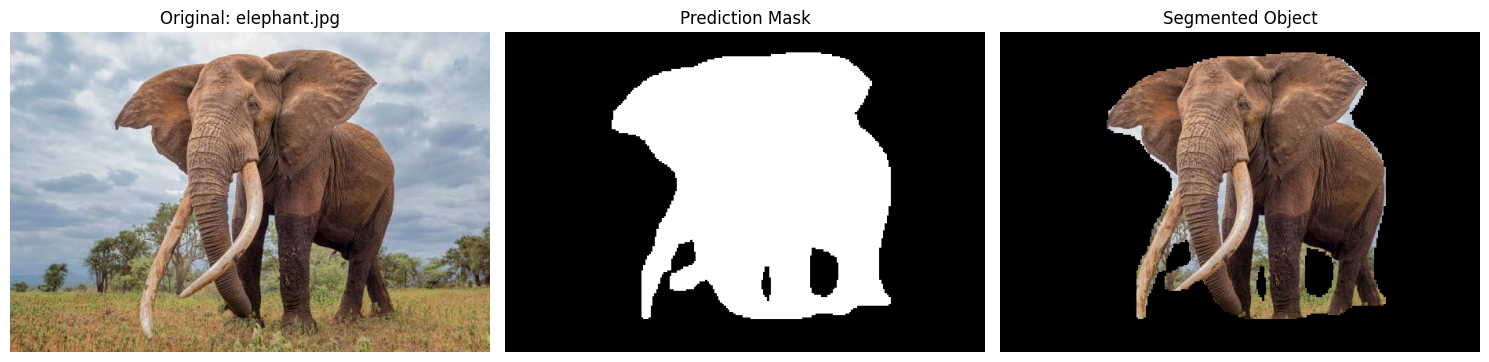


Processing: wall.jpg


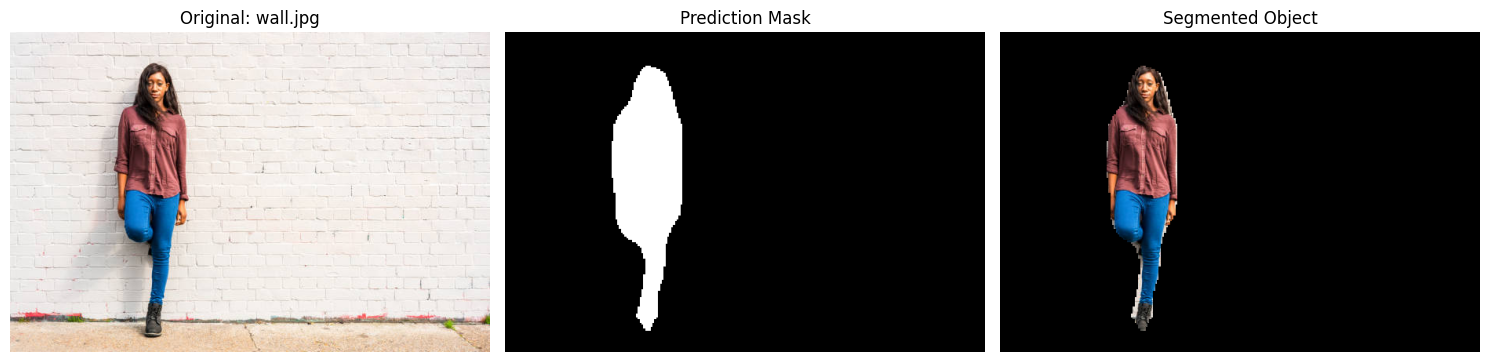


Processing: dog.jpg


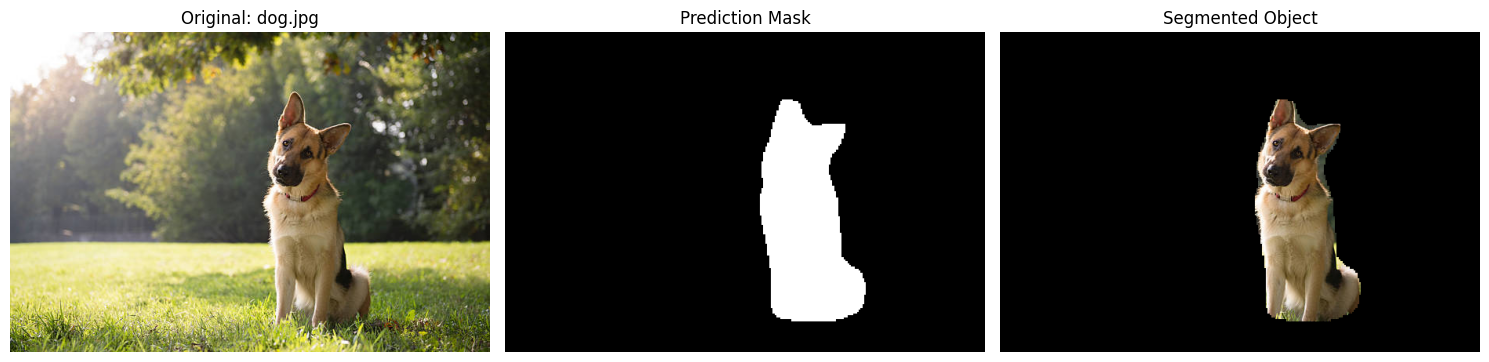


Processing: man-posing-with-crossed-arms.jpg


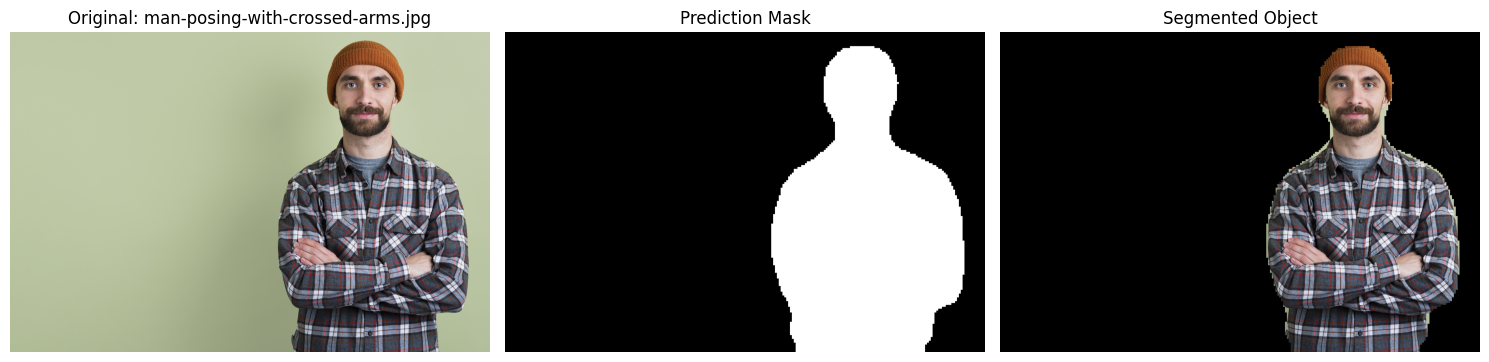


Processing: car.jpeg


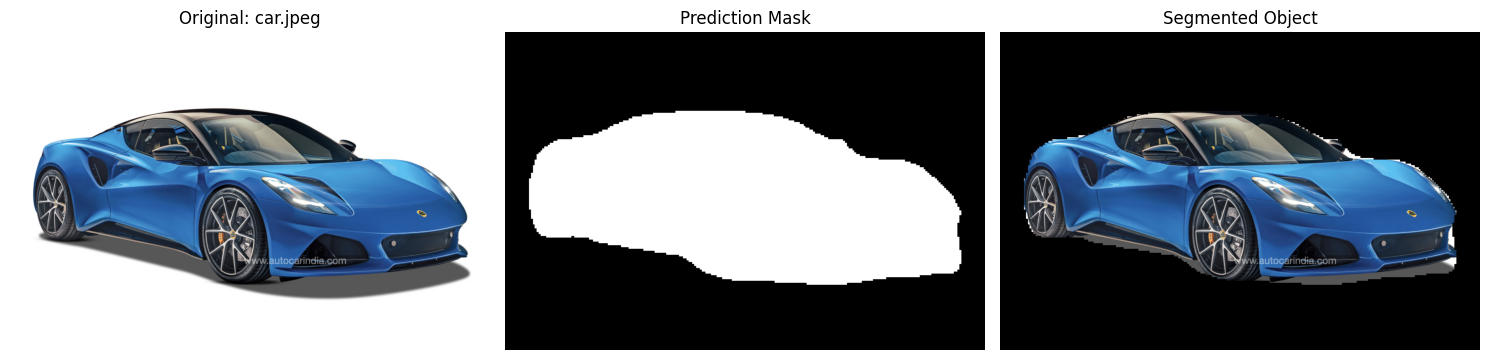


Processing: rose.jpg


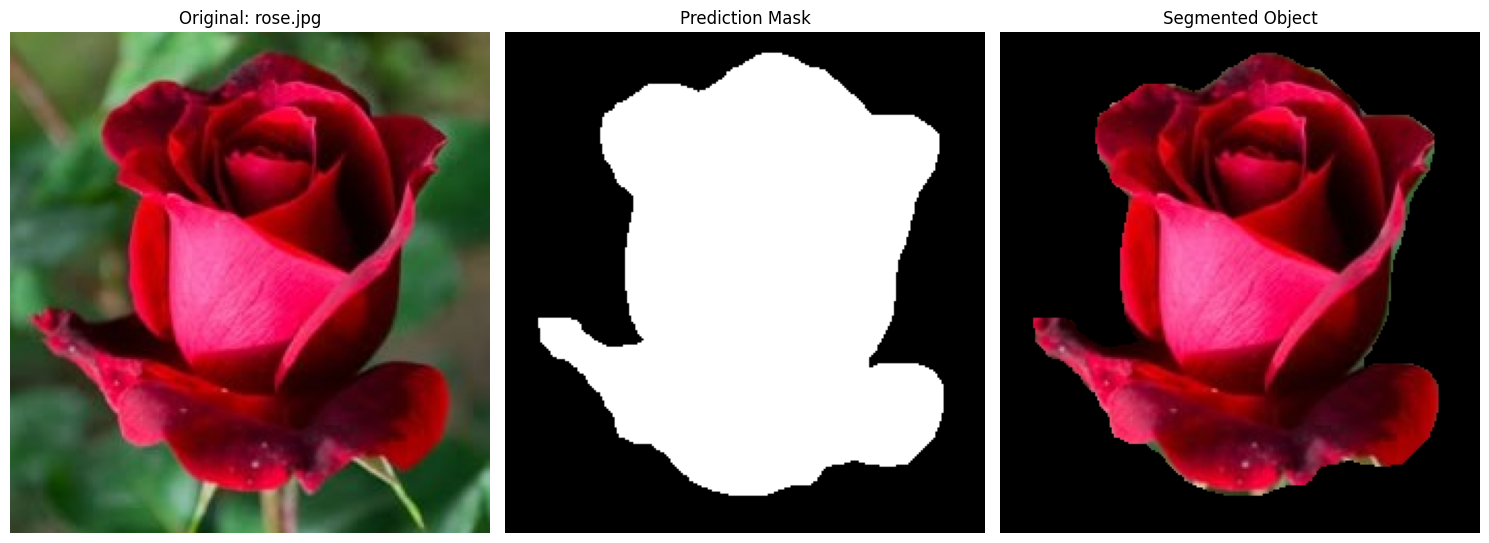


Processing: car.webp


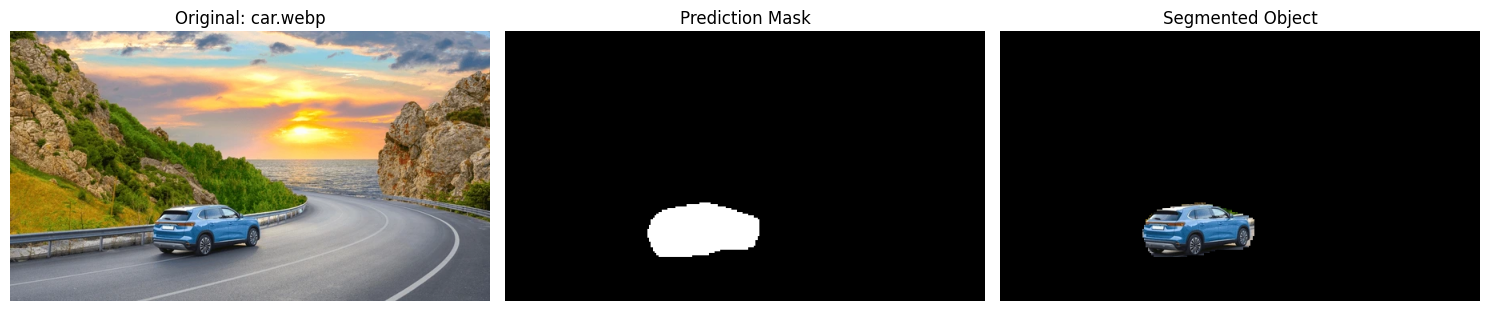


Processing: cap.jpg


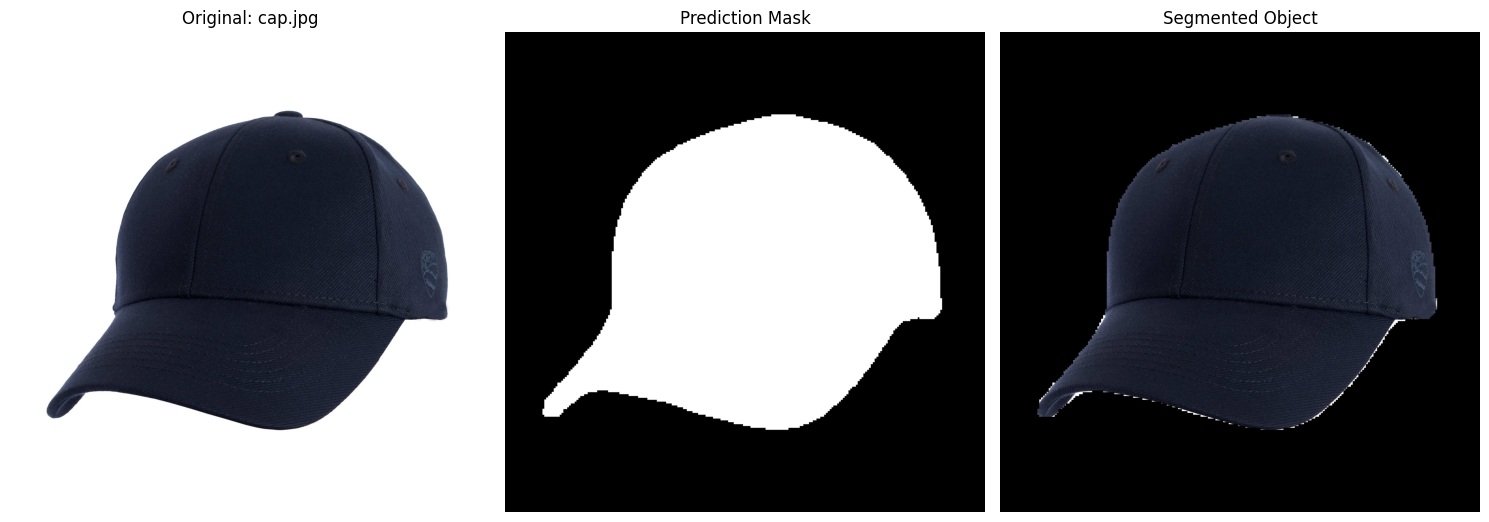


Processing: clock.jpg


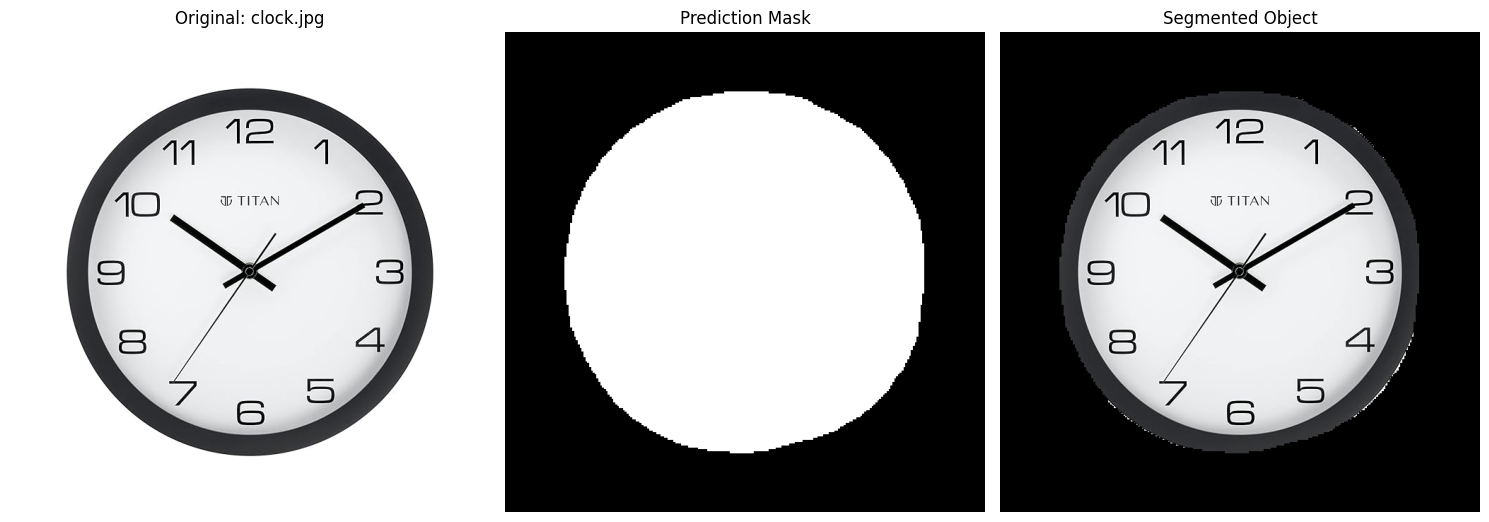


Processing: nature.jpg


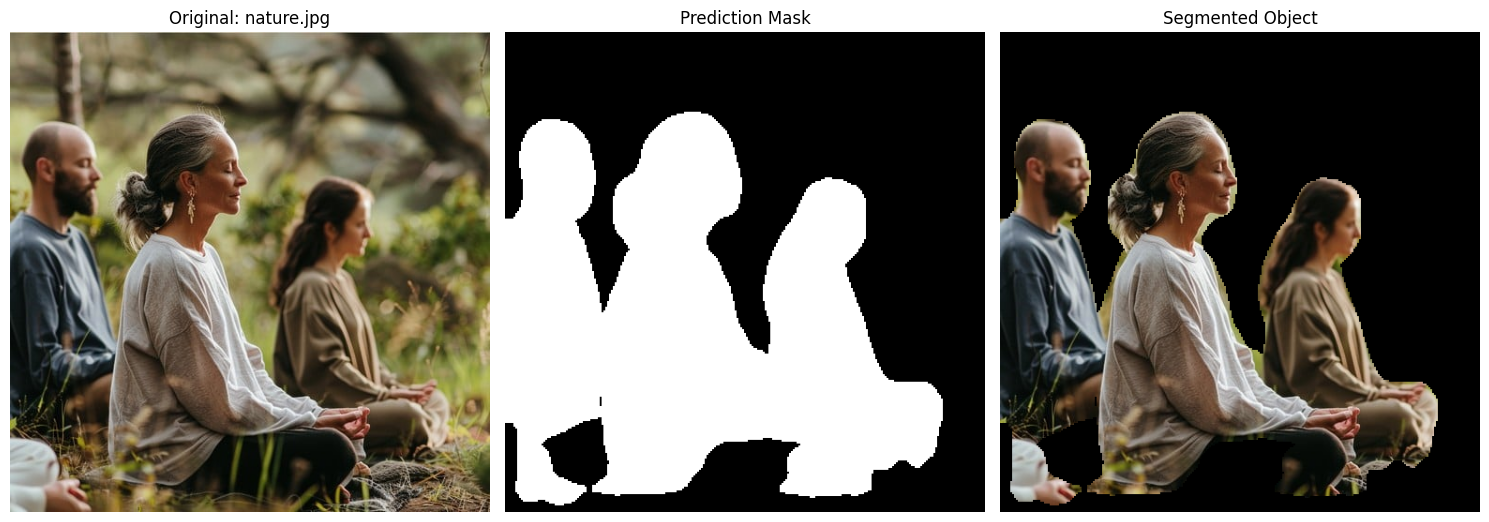


Processing: family.jpg


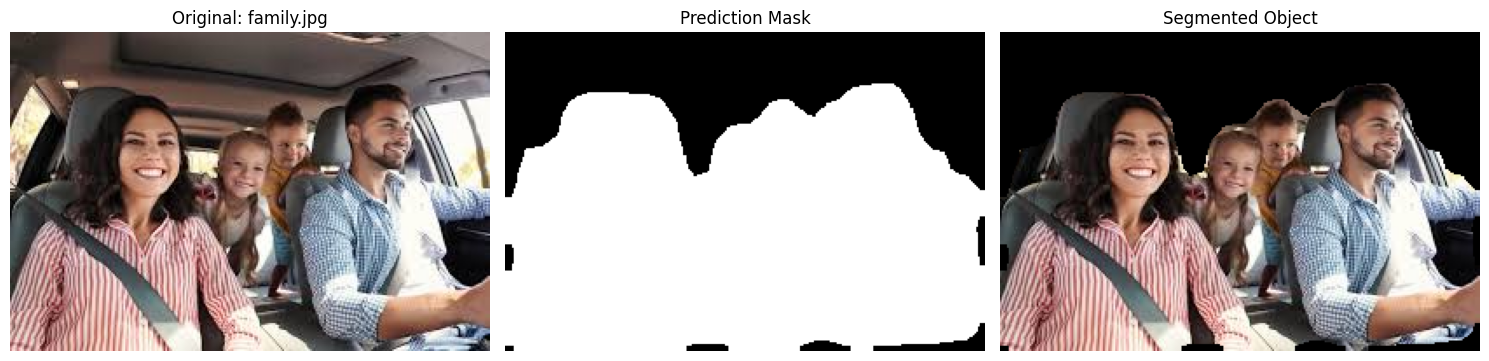


Processing: apple.jpg


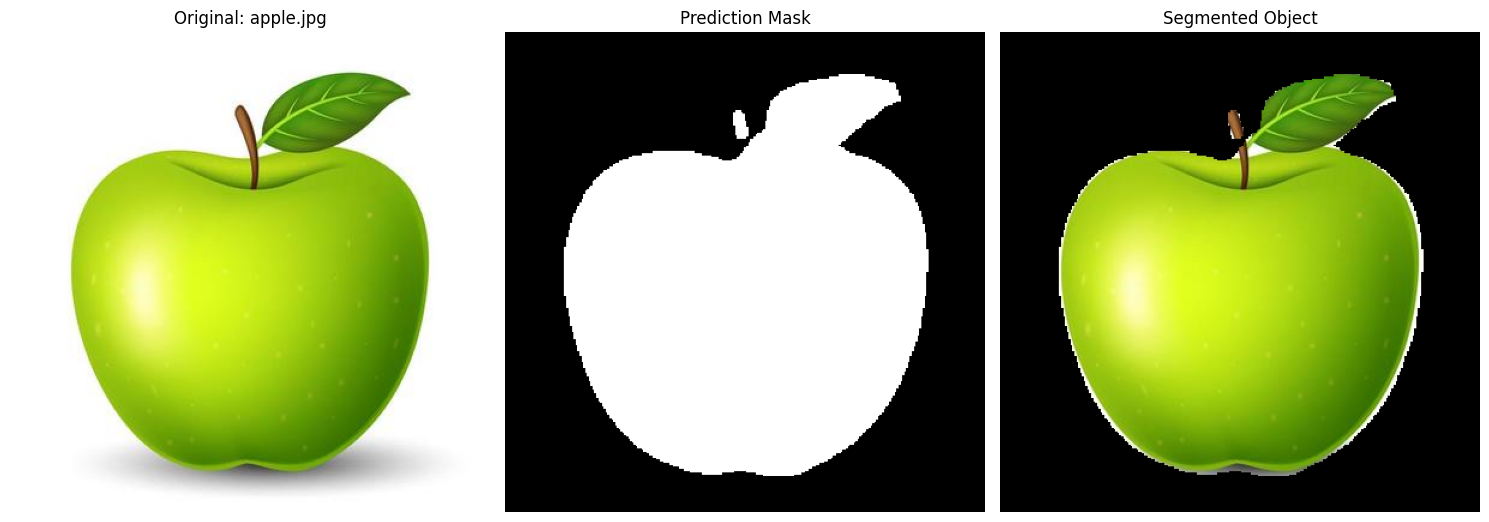


Processing: penguin.jpg


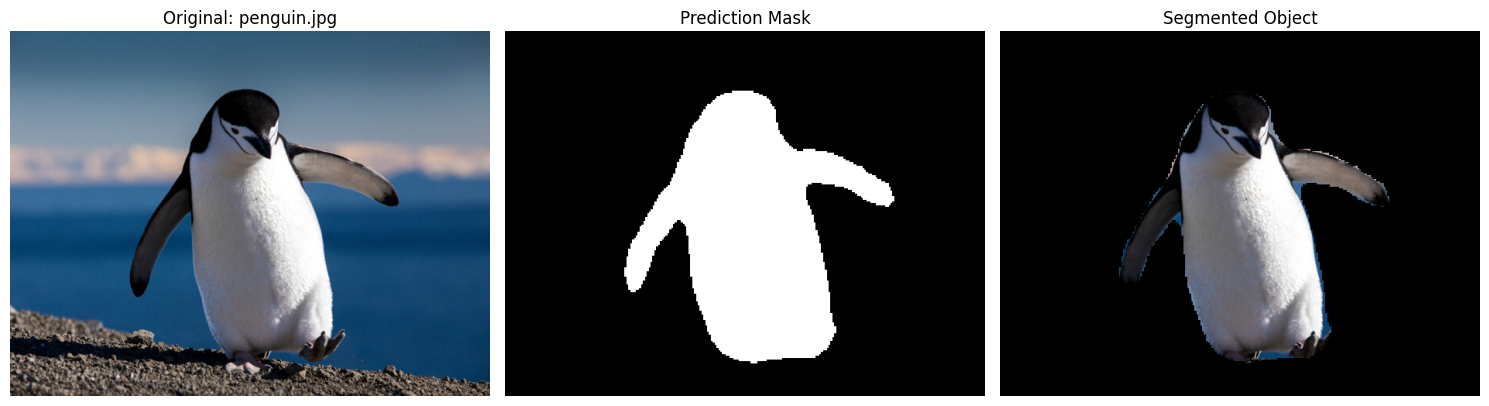


Processing: avocado.jpg


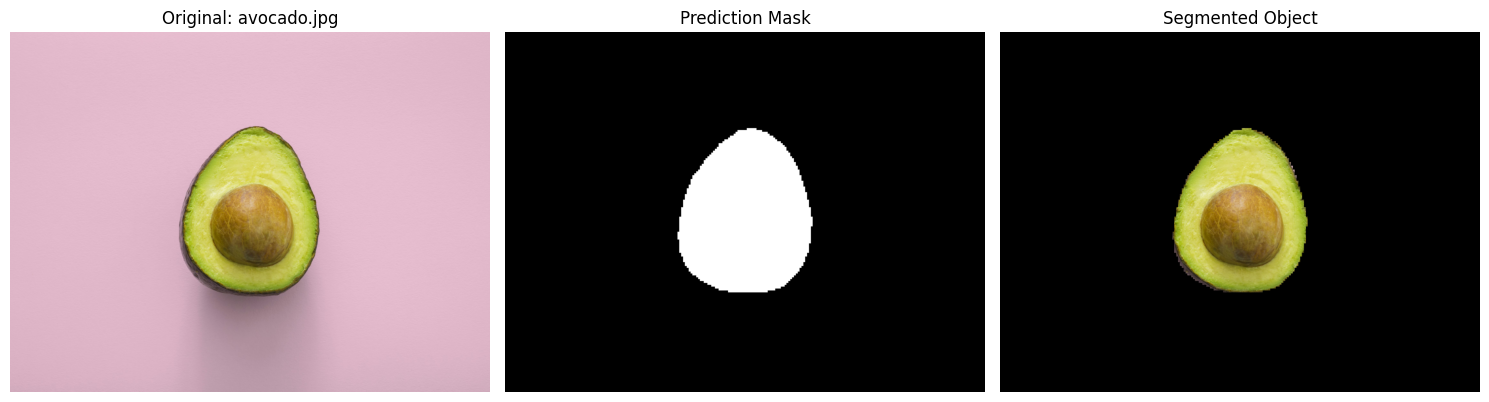

In [9]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
from PIL import Image

# === GOOGLE DRIVE MOUNTING (Required for path access) ===
# NOTE: Run this cell first, and follow the prompt to connect your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

# ============================ 1. CONFIGURATION ============================
# IMPORTANT: Verify these paths match your Google Drive structure.
MODEL_PATH = "/content/drive/MyDrive/AI-Vision/best_deeplabv3_finetuned.pth"
IMAGE_FOLDER_PATH = "/content/drive/MyDrive/AI-Vision/images" # Path to the FOLDER with your test images

NUM_CLASSES = 2
LONG_SIDE_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ============================ 2. MODEL DEFINITION & LOADING ============================

def load_model(path, device, num_classes=2):
    """Defines and loads the DeepLabV3 model with custom weights."""
    model = deeplabv3_resnet50(weights=None, aux_loss=True)

    # Modify the classifier heads for 2-class segmentation
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    if os.path.exists(path):
        print(f"✅ Loading model weights from: {path}")
        state_dict = torch.load(path, map_location=device)
        model.load_state_dict(state_dict)
    else:
        print(f"❌ Model weights not found at: {path}")
        print("Model initialized with random weights. Predictions will be incorrect.")

    model.to(device)
    model.eval()
    return model

# Load the model
model = load_model(MODEL_PATH, DEVICE, NUM_CLASSES)

# ============================ 3. UTILITY FUNCTIONS ============================

def preprocess_image(img: np.ndarray, long_side=LONG_SIDE_SIZE):
    """Resizes, converts to tensor, and normalizes the input image."""
    h, w = img.shape[:2]
    scale = long_side / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    # Use INTER_LINEAR for resizing the image itself
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Convert to tensor and normalize (from your notebooks)
    img_tensor = torch.tensor(img_resized / 255., dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # Standard ImageNet mean/std for normalization (from your notebooks)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    img_tensor = (img_tensor - mean) / std

    return img_tensor.to(DEVICE), (h, w)

def tta_predict(img_tensor: torch.Tensor):
    """Performs Test-Time Augmentation (TTA) prediction and averages results (from Internet-images-testing.ipynb)."""
    # Augmentations: Original, H-Flip, V-Flip, Rot-90, Rot-270
    aug_list = [
        lambda x: x,
        lambda x: torch.flip(x, [3]),
        lambda x: torch.flip(x, [2]),
        lambda x: torch.rot90(x, k=1, dims=[2, 3]),
        lambda x: torch.rot90(x, k=3, dims=[2, 3])
    ]
    outputs = []

    with torch.no_grad():
        for i, f in enumerate(aug_list):
            t = f(img_tensor)
            out = model(t)['out']

            # De-augment the output mask logits
            if i == 1: out = torch.flip(out, [3])
            elif i == 2: out = torch.flip(out, [2])
            elif i == 3: out = torch.rot90(out, k=3, dims=[2, 3])
            elif i == 4: out = torch.rot90(out, k=1, dims=[2, 3])

            outputs.append(out)

    # Average the logits
    return torch.mean(torch.stack(outputs), dim=0)

def postprocess_mask(mask_tensor: torch.Tensor, orig_size: tuple):
    """Converts prediction tensor to final mask, resizes, and applies morphology (from Internet-images-testing.ipynb)."""
    mask = torch.argmax(mask_tensor, dim=1).squeeze().cpu().numpy()

    # Resize mask using INTER_NEAREST
    mask = cv2.resize(mask.astype(np.uint8), (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)

    # Apply morphological operations for smoothing (from Internet-images-testing.ipynb)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.dilate(mask, kernel, iterations=1)

    return mask

def extract_object(img: np.ndarray, mask: np.ndarray):
    """Applies the mask to the image to extract the segmented object."""
    black_bg = np.zeros_like(img)
    black_bg[mask == 1] = img[mask == 1]
    return black_bg

# ============================ 4. EXECUTION (FOR LOCAL FOLDER) ============================

def run_segmentation_from_local_folder(folder_path: str):
    """Loads images from a local folder, runs the prediction pipeline, and displays results."""

    if not os.path.isdir(folder_path):
        print(f"❌ Error: Folder not found at {folder_path}. **Is Google Drive mounted and the path correct?**")
        return

    # Filter for common image extensions
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

    if not image_files:
        print(f"⚠️ No image files found in {folder_path}.")
        return

    print(f"Found {len(image_files)} images to process.")

    for filename in image_files:
        file_path = os.path.join(folder_path, filename)
        print(f"\nProcessing: {filename}")

        try:
            # Read image in BGR format
            img_bgr = cv2.imread(file_path)
            if img_bgr is None:
                print(f"   Skipping {filename} (could not read file. Is it a valid image?).")
                continue

            # Convert BGR to RGB
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            # 1. Preprocess
            img_tensor, orig_size = preprocess_image(img_rgb)

            # 2. Predict with TTA
            mask_tensor = tta_predict(img_tensor)

            # 3. Postprocess
            pred_mask = postprocess_mask(mask_tensor, orig_size)

            # 4. Extract Object
            segmented_result = extract_object(img_rgb, pred_mask)

            # 5. Visualize
            plt.figure(figsize=(15, 6))

            plt.subplot(1, 3, 1)
            plt.imshow(img_rgb)
            plt.title(f"Original: {filename}")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Prediction Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(segmented_result)
            plt.title("Segmented Object")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"   ❌ An error occurred while processing {filename}: {e}")

# Run the pipeline
run_segmentation_from_local_folder(IMAGE_FOLDER_PATH)

In [ ]:
#By choosing the images directly from System or Device.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
✅ Loading model weights from: /content/drive/MyDrive/AI-Vision/best_deeplabv3_finetuned.pth

--- Please select ONE or more image files from your system to test ---


Saving apple.jpg to apple (1).jpg
Saving avocado.jpg to avocado (3).jpg
Saving cap.jpg to cap (3).jpg
Saving car.jpeg to car (2).jpeg
Saving car.webp to car (2).webp
Saving clock.jpg to clock (2).jpg
Saving dog.jpg to dog (3).jpg
Saving elephant.jpg to elephant (3).jpg
Saving family.jpg to family (2).jpg
Saving man-posing-with-crossed-arms.jpg to man-posing-with-crossed-arms.jpg
Saving nature.jpg to nature (2).jpg
Saving penguin.jpg to penguin (2).jpg
Saving rose.jpg to rose (3).jpg
Saving wall.jpg to wall (3).jpg

Processing: apple (1).jpg


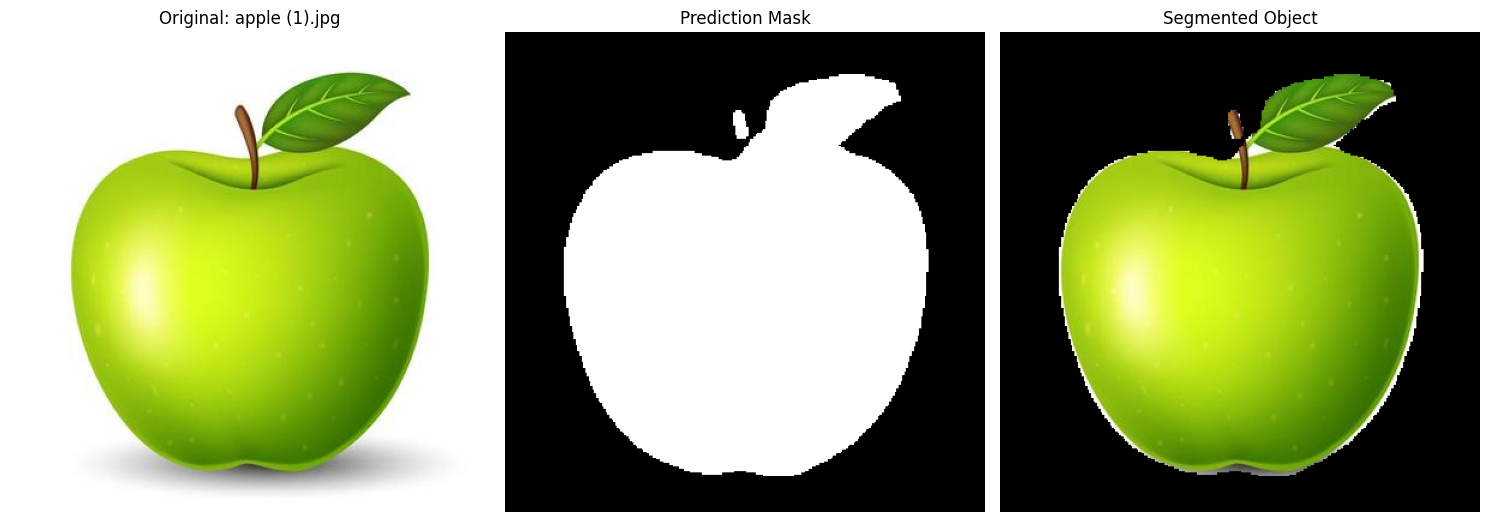


Processing: avocado (3).jpg


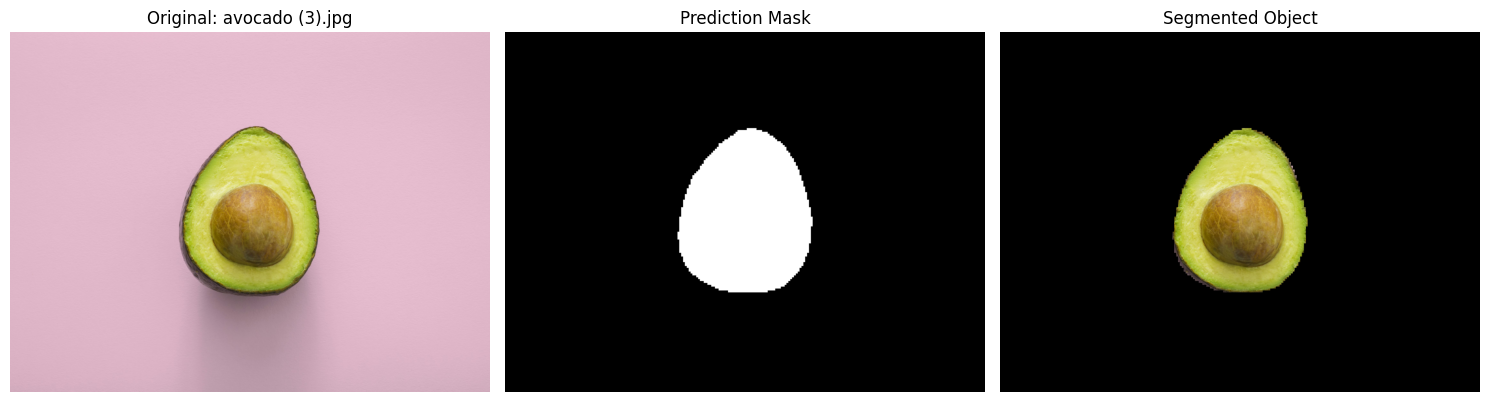


Processing: cap (3).jpg


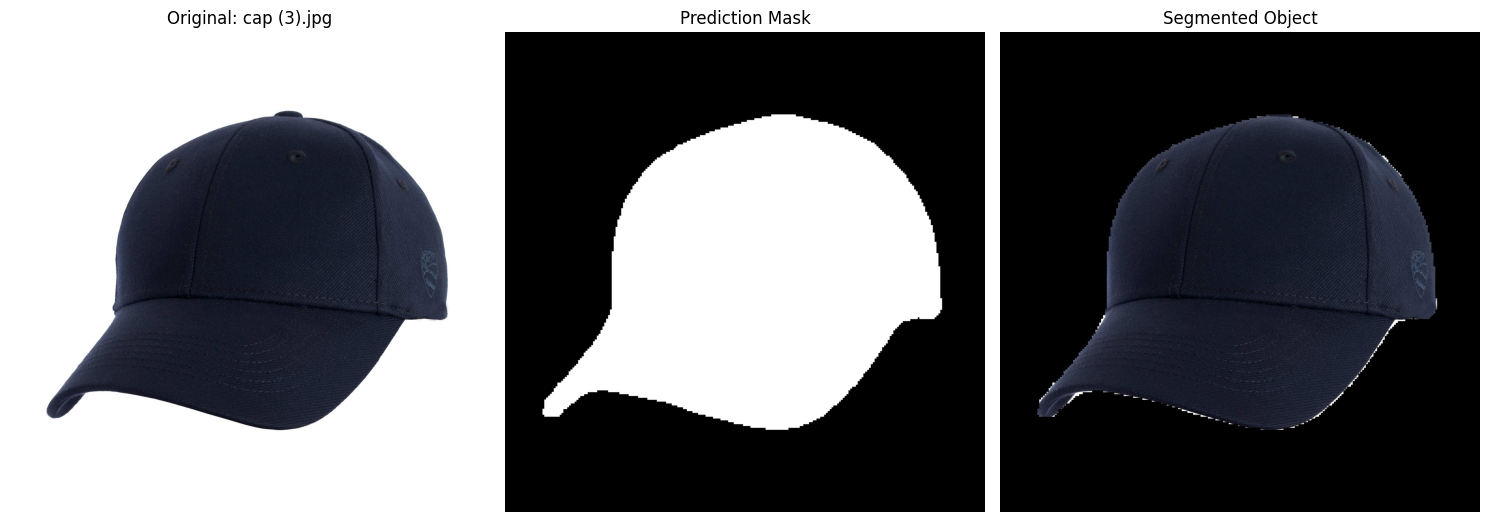


Processing: car (2).jpeg


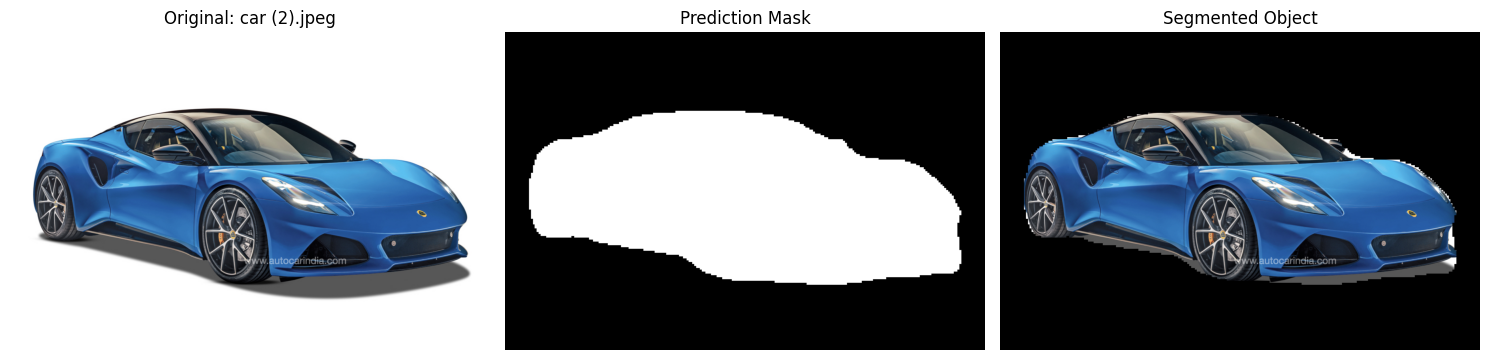


Processing: car (2).webp


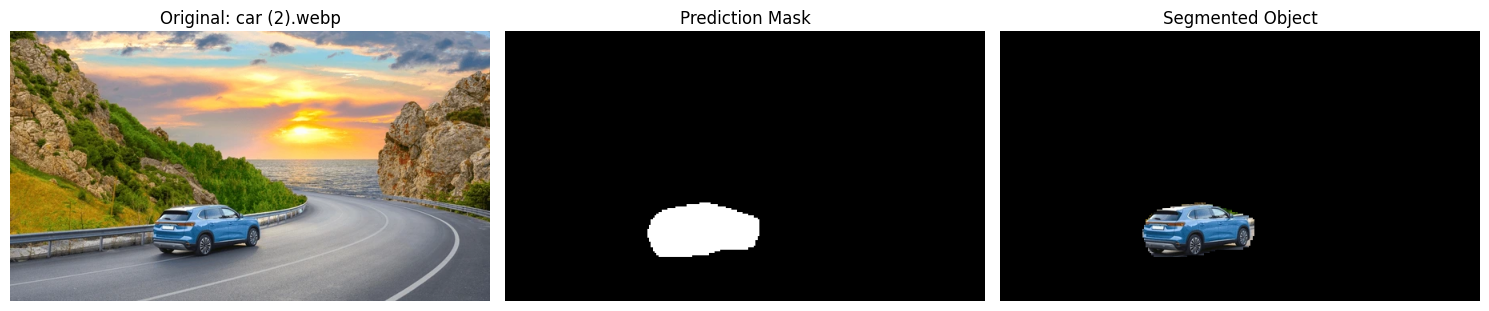


Processing: clock (2).jpg


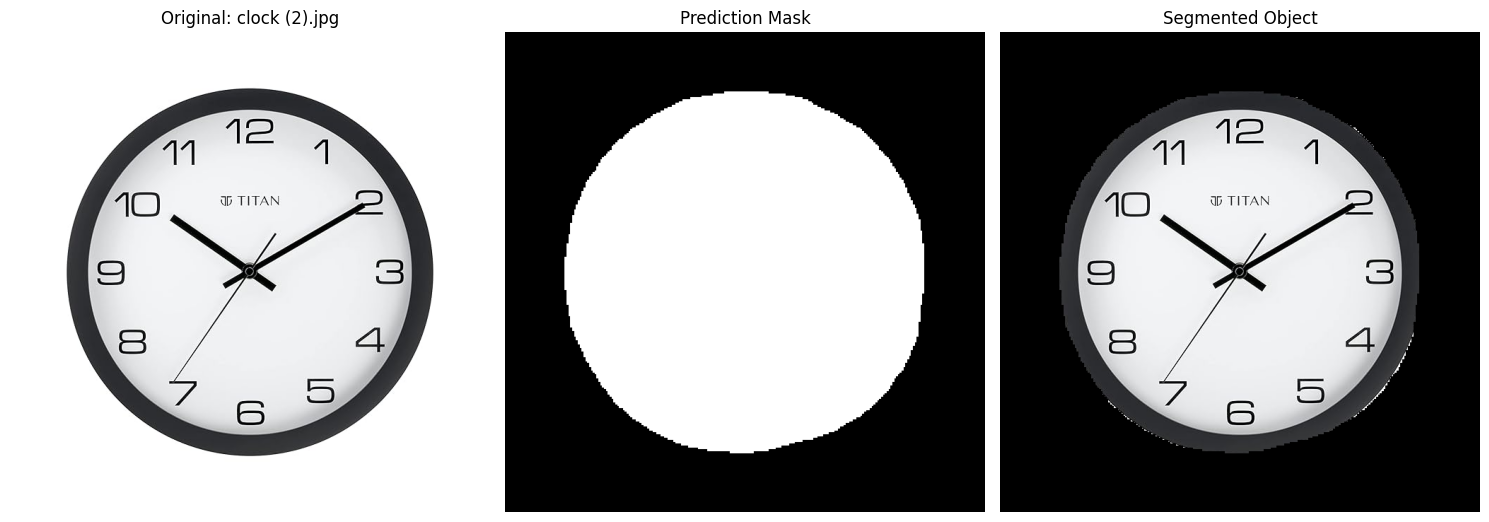


Processing: dog (3).jpg


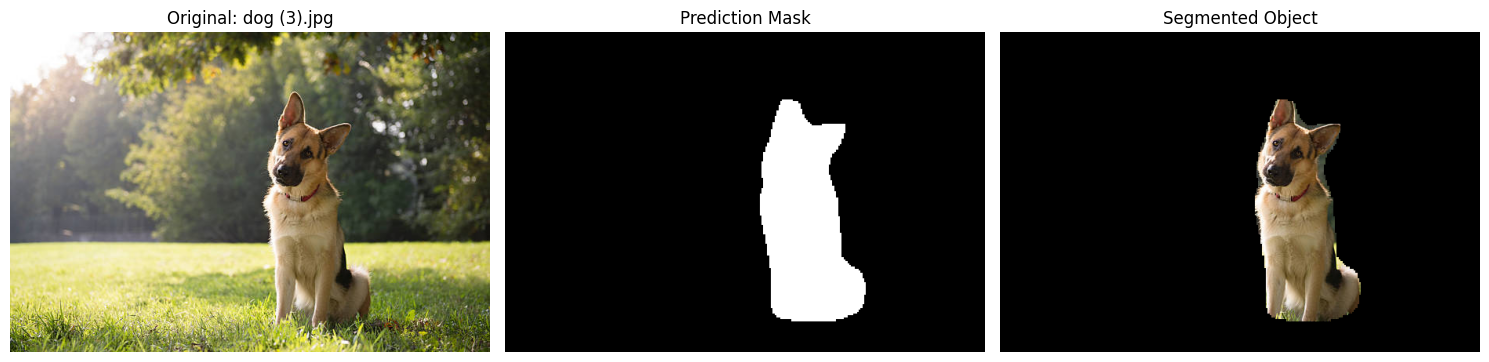


Processing: elephant (3).jpg


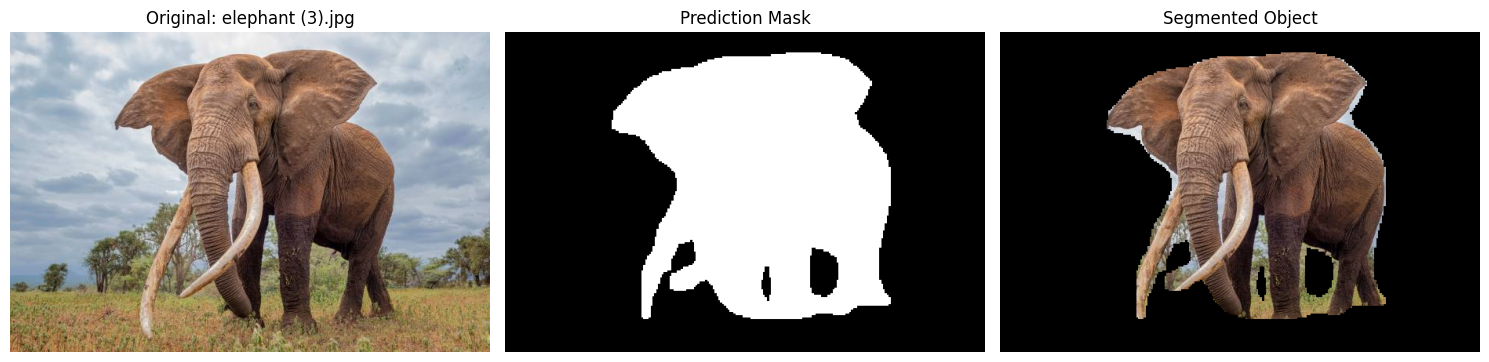


Processing: family (2).jpg


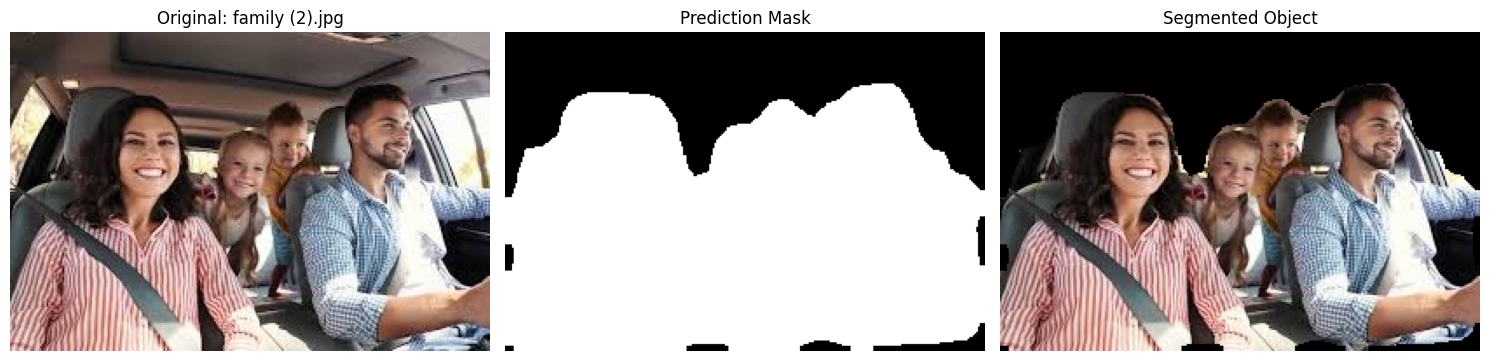


Processing: man-posing-with-crossed-arms.jpg


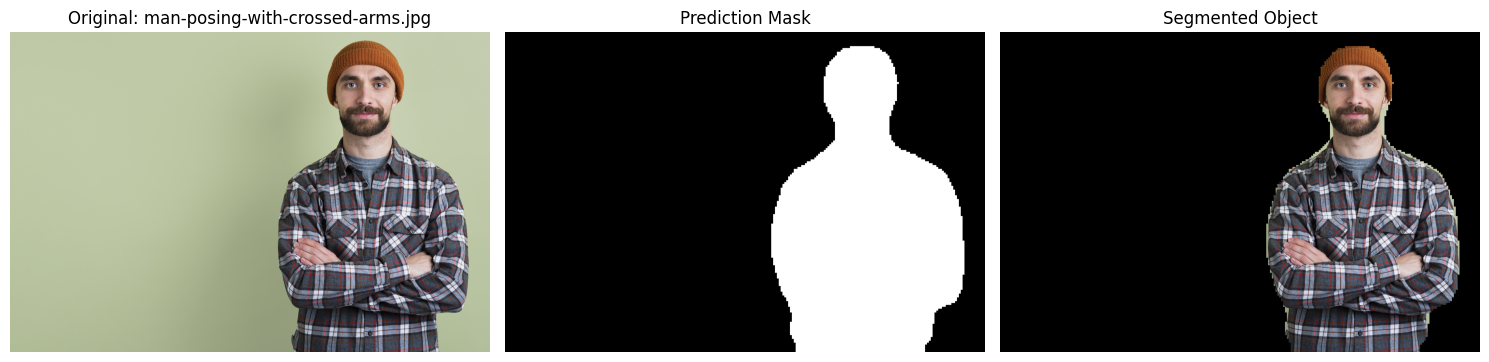


Processing: nature (2).jpg


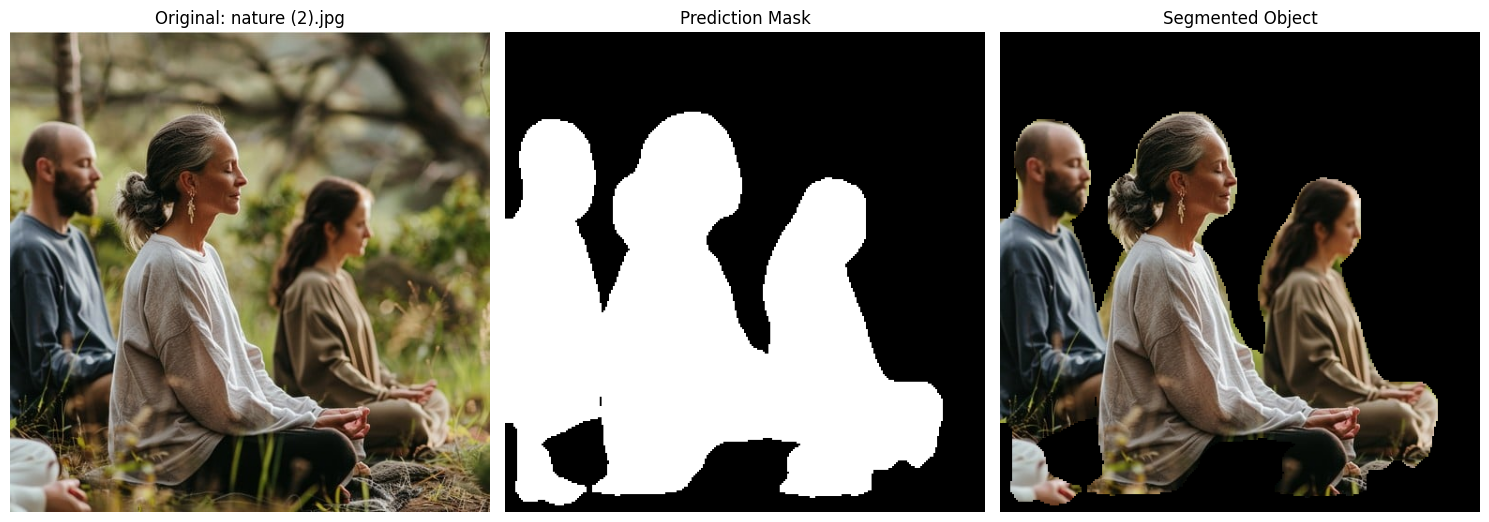


Processing: penguin (2).jpg


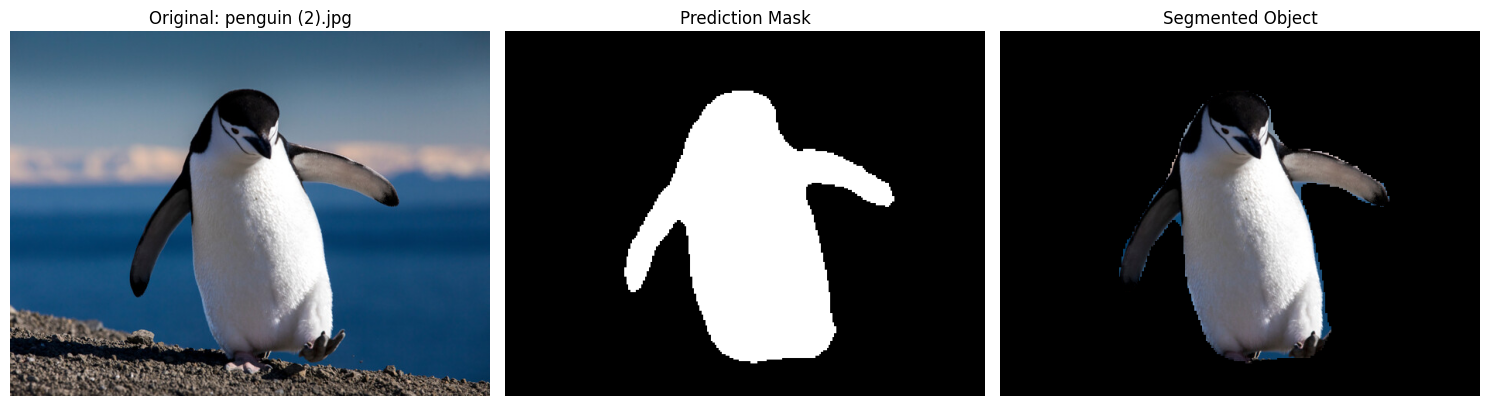


Processing: rose (3).jpg


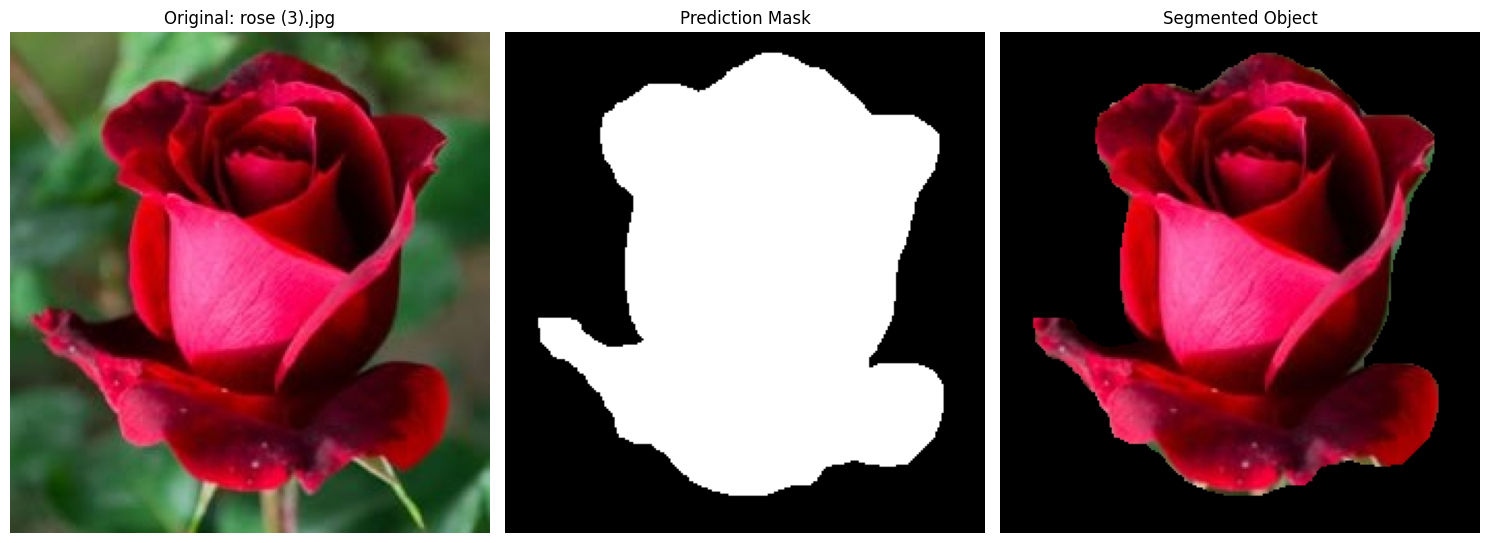


Processing: wall (3).jpg


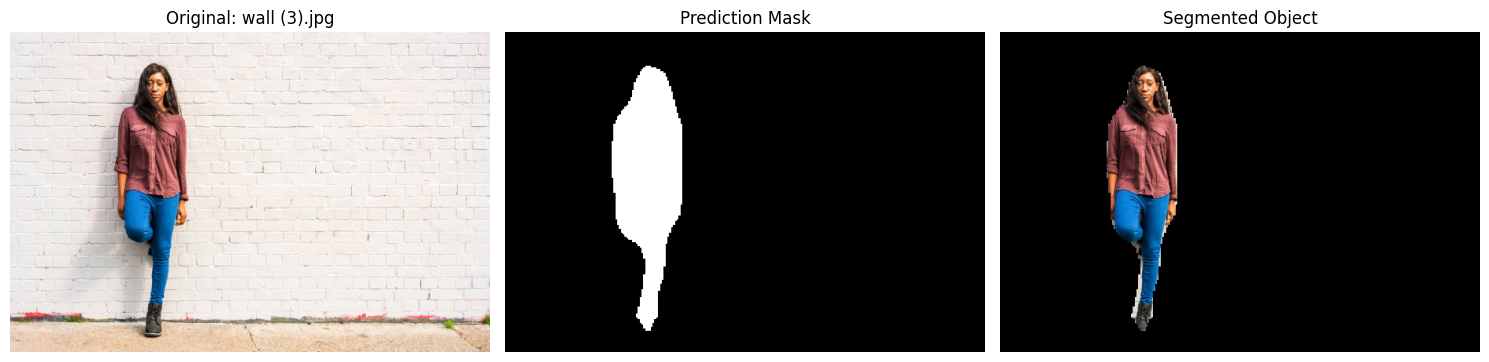

In [11]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
from PIL import Image
from io import BytesIO
import torchvision.transforms as T
from google.colab import files

# ==================== 0. GOOGLE DRIVE MOUNTING (Required for model weights) ====================
from google.colab import drive
try:
    drive.mount('/content/drive')
except Exception as e:
    print(f"⚠️ Could not mount Google Drive. Ensure you have authorized access. Error: {e}")

# ==================== 1. CONFIGURATION ====================
MODEL_PATH = "/content/drive/MyDrive/AI-Vision/best_deeplabv3_finetuned.pth"
NUM_CLASSES = 2
# Set LONG_SIDE_SIZE to 256 as found in your file, ensuring consistent scaling.
LONG_SIDE_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ==================== 2. MODEL DEFINITION & LOADING ====================

def load_model(path, device, num_classes=2):
    """Defines and loads the DeepLabV3 model with custom weights."""
    # Initialize DeepLabV3
    model = deeplabv3_resnet50(weights=None, aux_loss=True)

    # Modify classifier heads for 2-class setup (from your notebooks)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    if os.path.exists(path):
        print(f"✅ Loading model weights from: {path}")
        state_dict = torch.load(path, map_location=device)
        # Use strict=False for loading if the state dictionary includes 'aux_classifier' keys
        # that might be missing if the original training didn't use auxiliary loss,
        # though the model definition includes it.
        model.load_state_dict(state_dict, strict=True)
    else:
        print(f"❌ Model weights not found at: {path}")
        print("Model initialized with random weights. Predictions will be incorrect.")

    model.to(device)
    model.eval()
    return model

# Load the model
model = load_model(MODEL_PATH, DEVICE, NUM_CLASSES)

# ==================== 3. UTILITY FUNCTIONS (Enhanced Preprocessing & TTA) ====================

def preprocess_image(img_rgb: np.ndarray, long_side=LONG_SIDE_SIZE):
    """Resizes (keeping aspect ratio), converts to tensor, and normalizes."""
    h, w = img_rgb.shape[:2]
    # Scale image so the longest side is LONG_SIDE_SIZE
    scale = long_side / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    # Use INTER_LINEAR for resizing the image
    img_resized = cv2.resize(img_rgb, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Convert to tensor and normalize (from your notebooks)
    img_tensor = torch.tensor(img_resized / 255., dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # Standard ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    img_tensor = (img_tensor - mean) / std

    return img_tensor.to(DEVICE), (h, w)

def tta_predict(img_tensor: torch.Tensor):
    """Performs Test-Time Augmentation (TTA) prediction and averages results (from Internet-images-testing.ipynb)."""
    # Augmentations: Original, H-Flip, V-Flip, Rot-90, Rot-270
    aug_list = [
        lambda x: x,
        lambda x: torch.flip(x, [3]),
        lambda x: torch.flip(x, [2]),
        lambda x: torch.rot90(x, k=1, dims=[2, 3]),
        lambda x: torch.rot90(x, k=3, dims=[2, 3])
    ]
    outputs = []

    with torch.no_grad():
        for i, f in enumerate(aug_list):
            t = f(img_tensor)
            # Access 'out' for the main DeepLabV3 output
            out = model(t)['out']

            # De-augment the output mask logits
            if i == 1: out = torch.flip(out, [3])
            elif i == 2: out = torch.flip(out, [2])
            elif i == 3: out = torch.rot90(out, k=3, dims=[2, 3])
            elif i == 4: out = torch.rot90(out, k=1, dims=[2, 3])

            outputs.append(out)

    # Average the logits from all TTA predictions
    return torch.mean(torch.stack(outputs), dim=0)

def postprocess_mask(mask_tensor: torch.Tensor, orig_size: tuple):
    """Converts prediction tensor to final mask, resizes, and applies morphology (from Internet-images-testing.ipynb)."""
    # Get the class index with the highest logit value (0 or 1)
    mask = torch.argmax(mask_tensor, dim=1).squeeze().cpu().numpy()

    # Resize mask using INTER_NEAREST (Crucial to match original size)
    mask = cv2.resize(mask.astype(np.uint8), (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)

    # Apply morphological operations for smoothing and hole-filling
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.dilate(mask, kernel, iterations=1)

    return mask

def extract_object(img: np.ndarray, mask: np.ndarray):
    """Applies the mask to the image to extract the segmented object."""
    black_bg = np.zeros_like(img)
    # The mask contains 1 for the object class and 0 for background
    black_bg[mask == 1] = img[mask == 1]
    return black_bg

# ==================== 4. EXECUTION (Using Colab File Picker) ====================

# 1️⃣ Upload multiple images
print("\n--- Please select ONE or more image files from your system to test ---")
uploaded = files.upload()
image_paths = list(uploaded.keys())

if not image_paths:
    print("❌ No files selected. Exiting.")

# 2️⃣ Process all uploaded images
for filename in image_paths:
    try:
        # Load image from the uploaded bytes (this is safer than reading the path directly)
        img_bytes = BytesIO(uploaded[filename])
        img_pil = Image.open(img_bytes).convert("RGB")
        img_rgb = np.array(img_pil)

        print(f"\nProcessing: {filename}")

        # 1. Preprocess
        img_tensor, orig_size = preprocess_image(img_rgb)

        # 2. Predict with TTA (for robust, 'correct' results)
        mask_tensor = tta_predict(img_tensor)

        # 3. Postprocess
        pred_mask = postprocess_mask(mask_tensor, orig_size)

        # 4. Extract Object
        segmented_result = extract_object(img_rgb, pred_mask)

        # 5. Visualize
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb)
        plt.title(f"Original: {filename}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Prediction Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(segmented_result)
        plt.title("Segmented Object")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"   ❌ An error occurred while processing {filename}: {e}")